# Lab 6 Report: 
## Audio Filtering with Gated RNNs


### Name: Ali Issa Salman

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import IPython

from scipy.io.wavfile import write

In [ ]:
from IPython.display import Image # For displaying images in colab jupyter cell

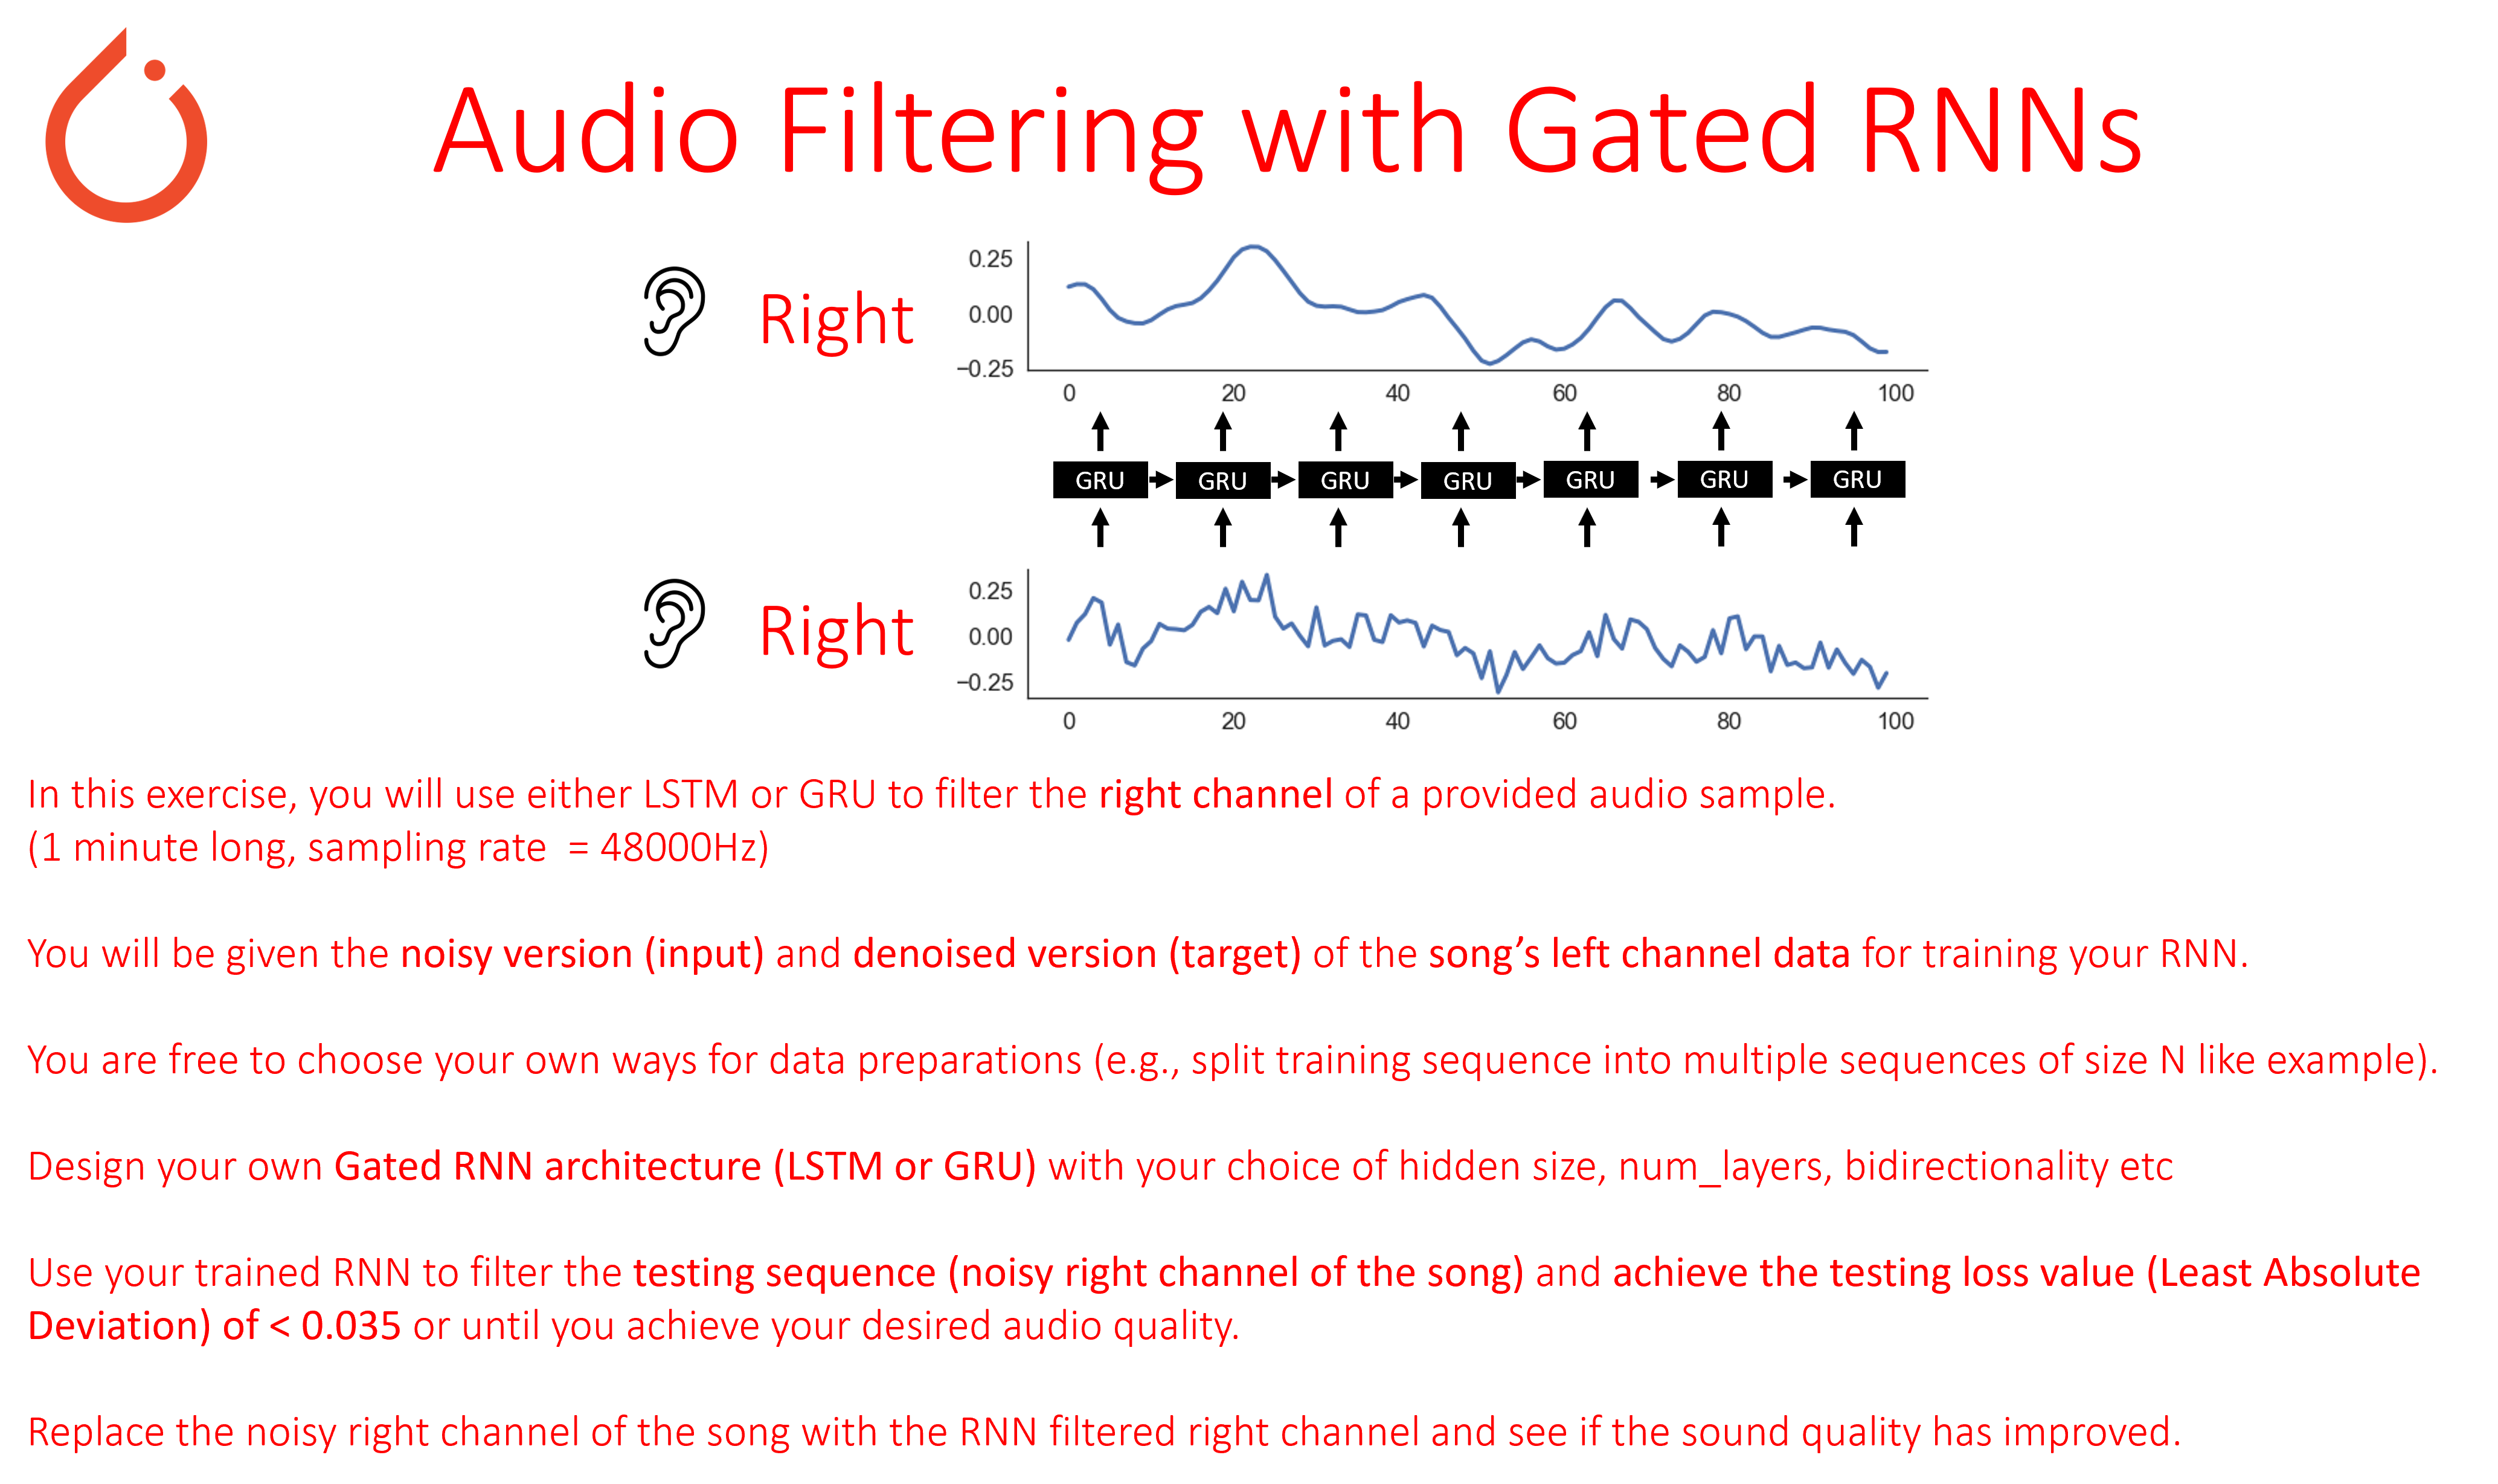

In [ ]:
Image('lab6_exercise.png', width = 1000)

In [ ]:
sns.set(style = 'white', font_scale = 1.5)

## Prepare Data

In [ ]:
# Listen to audio with noisy right channel
# Our goal is to use RNN to denoise the right channel
# USE HEADPHONES OR SET YOUR LAPTOP VOLUME TO LOW IF YOU ARE LISTENING IN THE CLASS

import IPython
IPython.display.Audio("TSR_noisy.wav")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train_input_seqs = np.load('audio_train_inputs.npy') # Noisy left channel audio (training inputs to your RNN)
train_output_seqs = np.load('audio_train_targets.npy') # Ground truth left channel audio (trining targets for your RNN)

# Print the length of training features and targets
print(len(train_input_seqs), len(train_output_seqs))

2754000 2754000


In [ ]:
# Reshape train_input_seqs and train_output_seqs to 2D arrays
# Each row corresponds to a single training input/target sequence
# e.g., if your training sequence length = 100 -> train_input_seqs/output_seqs should have shape (27540, 100)
# Feel free to choose your own training sequence length

# try to split data first: take the first 100,000 data for training. This seems to give good performance in the end.
train_input_seqs = train_input_seqs[:100000]
train_output_seqs = train_output_seqs[:100000]
#print(len(train_input_seqs))

# need to reshape to get 2D array where each row is a training input/target sequence and the columns is each feature in the sequence
train_input_seqs = train_input_seqs.reshape(1000,100)
train_output_seqs = train_output_seqs.reshape(1000,100)

In [ ]:
# Reshape train_input_seqs and output_seqs again to conform to PyTorch (sample size (N), sequence length, # of features)

# (num of features in input sample, length of input sequence, num of features in each sequence)
train_input_seqs = train_input_seqs.reshape((train_input_seqs.shape[0],-1,1))
train_output_seqs = train_output_seqs.reshape((train_output_seqs.shape[0],-1,1))

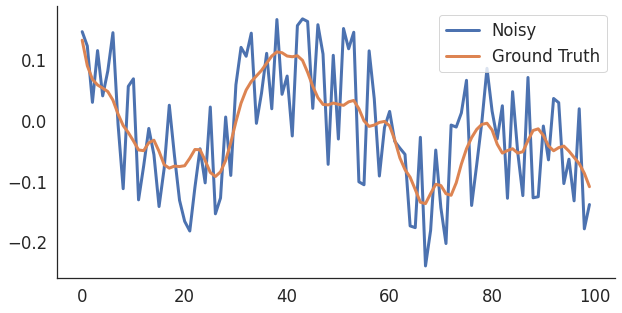

In [ ]:
# let's plot one of the training input sequence/output target (10th sample)
# Feel free to plot a different sample

plt.figure(figsize = (10, 5))

plt.plot(train_input_seqs[999], label ='Noisy', linewidth = 3)
plt.plot(train_output_seqs[999], label ='Ground Truth', linewidth = 3)
plt.legend()
sns.despine()

## Define Model

In [ ]:
# class representing the RNN model that works to denoise the input signal
class Denoiser_RNN(torch.nn.Module):
    
    # method that holds network architecture.
    #   input_size - number of expected features in input sample
    #   hidden_size - number of expected features in hidden layer 
    #   num_layers - number of recurrence layers 
    #   output_size - number of expected features in output sample
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        
        super(Denoiser_RNN, self).__init__()
        
        self.gru = torch.nn.GRU(input_size=input_size,hidden_size=hidden_size,
                                num_layers=num_layers,
                                batch_first = True,
                                bidirectional=True)
        self.decoder = torch.nn.Linear(2*hidden_size,output_size) # 2*: go through sample backward and forward
        self.output_activation = torch.nn.Tanh()

    # feed forward function sends information through each layer 
    #   input_seq - input sequence of features into the network
    #   hidden_state - output from gru into the decoder   
    def forward(self, input_seq, hidden_state):
        
        pred, hidden = self.gru(input_seq, hidden_state)
        denoised_seq = self.output_activation(self.decoder(pred))
        
        return denoised_seq

## Define Hyperparameters

In [ ]:
# Define your model
denoiser_rnn = Denoiser_RNN(input_size = 1, hidden_size = 120,
                            num_layers = 1, output_size = 1)

# Define lr and epochs
learning_rate = 0.0006    
epochs = 100

# Define mini-batch size
batchsize = 250

# Use L1Loss to minimize least absolute deviation + optimizer
loss_func = torch.nn.L1Loss()
optimizer = torch.optim.Adam(denoiser_rnn.parameters(), lr= learning_rate)

# Print out model specifics, add .cuda() if using GPU
#denoiser_rnn.cuda()
denoiser_rnn

Denoiser_RNN(
  (gru): GRU(1, 120, batch_first=True, bidirectional=True)
  (decoder): Linear(in_features=240, out_features=1, bias=True)
  (output_activation): Tanh()
)

## Identify Tracked Values

In [ ]:
# Empty list to keep track of training loss

train_loss_list = []

## Train Model

In [ ]:
# Convert your training data into torch tensors

train_input_seqs = torch.from_numpy(train_input_seqs).float()
train_output_seqs = torch.from_numpy(train_output_seqs).float()

#train_input_seqs = torch.from_numpy(train_input_seqs).float()
#train_output_seqs = torch.from_numpy(train_output_seqs).float()




# Split your training data into mini-batches
train_batches_features = torch.split(train_input_seqs, batchsize)
train_batches_targets = torch.split(train_output_seqs, batchsize)

# where the model training will take place 
# will keep track of the training loss every epoch
for epoch in range(epochs):
    
    for k in range(len(train_batches_features)):
      hidden_state = None
      pred = denoiser_rnn(train_batches_features[k],hidden_state)
      optimizer.zero_grad()
      loss = loss_func(pred,train_batches_targets[k])
      train_loss_list.append(loss.item())
      loss.backward()
      optimizer.step()

    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-len(train_batches_features):]))

Averaged Training Loss for Epoch  0 :  0.16141276620328426
Averaged Training Loss for Epoch  1 :  0.15035425871610641
Averaged Training Loss for Epoch  2 :  0.1392174493521452
Averaged Training Loss for Epoch  3 :  0.12734643556177616
Averaged Training Loss for Epoch  4 :  0.11364711821079254
Averaged Training Loss for Epoch  5 :  0.09705010615289211
Averaged Training Loss for Epoch  6 :  0.07544254232198
Averaged Training Loss for Epoch  7 :  0.04815444815903902
Averaged Training Loss for Epoch  8 :  0.043743508867919445
Averaged Training Loss for Epoch  9 :  0.045708201825618744
Averaged Training Loss for Epoch  10 :  0.0386254508048296
Averaged Training Loss for Epoch  11 :  0.04015135392546654
Averaged Training Loss for Epoch  12 :  0.03946581296622753
Averaged Training Loss for Epoch  13 :  0.03741879854351282
Averaged Training Loss for Epoch  14 :  0.037666818127036095
Averaged Training Loss for Epoch  15 :  0.037819803692400455
Averaged Training Loss for Epoch  16 :  0.037337895

## Visualize & Evaluate Model

### Visualizing Training Loss

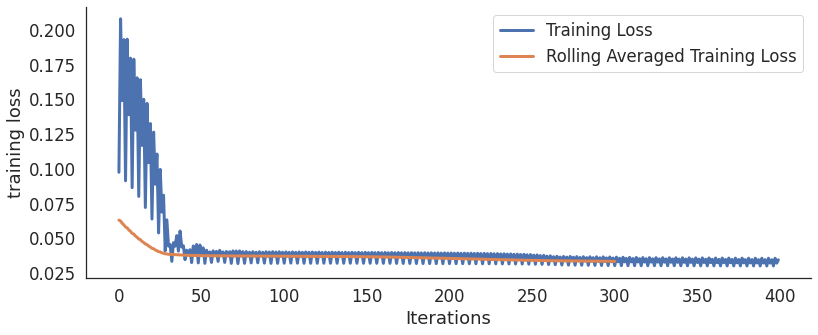

In [ ]:
# Plot your training loss throughout the training 

plt.figure(figsize = (13, 5))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')

plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

### Computing Testing Loss

In [ ]:
# Load test features (Noisy right channel) and test targets for computing the test loss

test_input_seqs = np.load('audio_test_inputs.npy') # Noisy right channel audio (to be used as inputs to your trained RNN)
test_output_seqs = np.load('audio_test_targets.npy') # Groundtruth right channel audio (to compute the test loss)

In [ ]:
# Test features/targets have same dimension as training feature/targets

print(len(test_input_seqs), len(test_output_seqs))

2754000 2754000


In [ ]:
# now for the testing sample
# Convert your test_input_seqs and output_seqs into torch tensors
test_input_seqs = torch.from_numpy(test_input_seqs).float()
test_output_seqs = torch.from_numpy(test_output_seqs).float()

# Reshape your test_input_seqs and output_seqs to 2D arrays as you did with train_input_seqs and output_seqs
test_input_seqs = test_input_seqs[:100000]
test_output_seqs = test_output_seqs[:100000]

test_input_seqs = test_input_seqs.reshape(1000,100)
test_output_seqs = test_output_seqs.reshape(1000,100)

# Reshape the test_input_seqs and output_seqs again to conform to (sample size (N), sequence length, # of features)
test_input_seqs = test_input_seqs.reshape((test_input_seqs.shape[0],-1,1))
test_output_seqs = test_output_seqs.reshape((test_output_seqs.shape[0],-1,1))

In [ ]:
# Each noisy test input sequence is fed into your trained RNN to produce denoised outputs
# We need to take mini-batch approach since our test_features is too big to feed it all in once (i.e. not enough memory)

# Split the test_features and targets to mini-batches
test_batches_features = torch.split(test_input_seqs, batchsize)
test_batches_targets = torch.split(test_output_seqs, batchsize)

batch_split_num_test = len(test_batches_features)

# Empty lists to keep track of RNN denoised test sequences and test losses
test_prediction = []
test_losses = []

# Turn on no_grad() since we aren't performing backprop during this process
with torch.no_grad():
    
    for k in range(batch_split_num_test):
        
        # Feed in k-th test mini-batch to trained RNN
        test_pred = denoiser_rnn(test_batches_features[k], None)
        # Compre the test_pred with test target sequence to compute testing loss
        test_loss = loss_func(test_pred, test_batches_targets[k])
        
        # Use torch.squeeze() to make test_pred to shape (batchsize, seq_len) and convert it to numpy array
        test_pred_numpy = torch.squeeze(test_pred).numpy()
        
        # Append both test_pred_numpy and test_loss 
        test_prediction.append(test_pred_numpy)
        test_losses.append(test_loss.item())
        
# Final testing loss is the average of all the test_losses from mini-batches        
print("Testing Loss (Least Absolute Deviations): ", np.mean(test_losses))

Testing Loss (Least Absolute Deviations):  0.03490993054583669


### Creating a new audio with denoised right channel sequence

In [ ]:
# test_prediction is a list of 2D arrays where each array has shape (batchsize, seq_len)
# Vertically stack all appended 2D arrays so that we have a single 2D array
test_prediction = np.vstack(test_prediction)

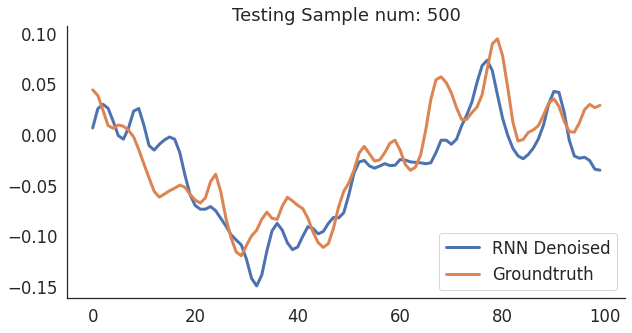

In [ ]:
# We can visualize RNN denoised test sequence vs ground truth test sequence for particular sample
test_sample_num = 500
    
plt.figure(figsize = (10, 5))

plt.plot(test_prediction[test_sample_num], label='RNN Denoised', linewidth = 3)
plt.plot(test_output_seqs[test_sample_num], label='Groundtruth', linewidth = 3)
plt.legend()
plt.title("Testing Sample num: {}".format(test_sample_num))
sns.despine()

In [ ]:
# Reshape the test_prediction to 1D array of size 2754000 so that we can use it as the right channel of the song
test_prediction = test_prediction.reshape(100000)

# Reshape the train_output_seqs (ground truth left channel of the song) to 1D array as well
train_output_seqs = train_output_seqs.reshape(100000)

# Construct an array 'fixed_audio' of size (2754000, 2) 
# where the first column (left channel) is 1D reshaped train_output_seqs (groundtruth left channel)
# And second column (right channel) is the 1D reshaped test_prediction (RNN denoised)

#fixed_audio = np.empty(len(train_output_seqs))
fixed_audio = np.column_stack([train_output_seqs, test_prediction])

In [ ]:
# Scale the fixed_audio so that it's in int16 form and write it into a new audio file

scaled = np.int16(fixed_audio/np.max(np.abs(fixed_audio)) * 32767)
write('TSR_fixed.wav', 48000, scaled)

In [ ]:
# Listen to the new audio with denoised right channel
# USE HEADPHONES OR SET YOUR LAPTOP VOLUME TO LOW IF YOU ARE LISTENING IN THE CLASS

IPython.display.Audio("TSR_fixed.wav")

In [ ]:
# Compare your denoised audio with ground truth audio for reference
# USE HEADPHONES OR SET YOUR LAPTOP VOLUME TO LOW IF YOU ARE LISTENING IN THE CLASS

IPython.display.Audio("TSR.wav")

Output hidden; open in https://colab.research.google.com to view.